### Introduction

**What are stromal features?** 🔬 Stromal features are quantitative measurements of the stromal extracellular matrix (ECM) which is the connective tissue that supports the functional cells of an organ. Analyzing the stroma is critical because it's not just passive filler; it actively interacts with and influences the behavior of cells. The stroma, is composed of various components, including fibroblasts, immune cells, and the extracellular matrix (ECM). Histolytics focuses on characterizing this ECM, particularly the arrangement of collagen fibers and the staining patterns of the stroma.

Histolytics allows you to compute two main types of features to characterize the stroma:

**Collagen Fiber Features:** These features are derived from the collagen fibers that make up a significant portion of the ECM. By analyzing the structure and arrangement of these fibers, you can quantify subtle changes in the micro-environment. Changes in these features can be linked to disease progression, as tumors often remodel the surrounding collagen to facilitate invasion. 

**Hematoxylin and Eosin (H&E) Intensity Features:** Histolytics can measure the intensity of the H&E stain components within the stromal ECM. These intensity measures provide a simple way to quantify the composition and state of the stroma. By analyzing these features, you can gain a deeper understanding of the stromal composition and how it changes in different biological and pathological conditions. For example, desmoplastic reactions in the stroma can lead to changes in the H&E staining patterns which can be detected through these features.

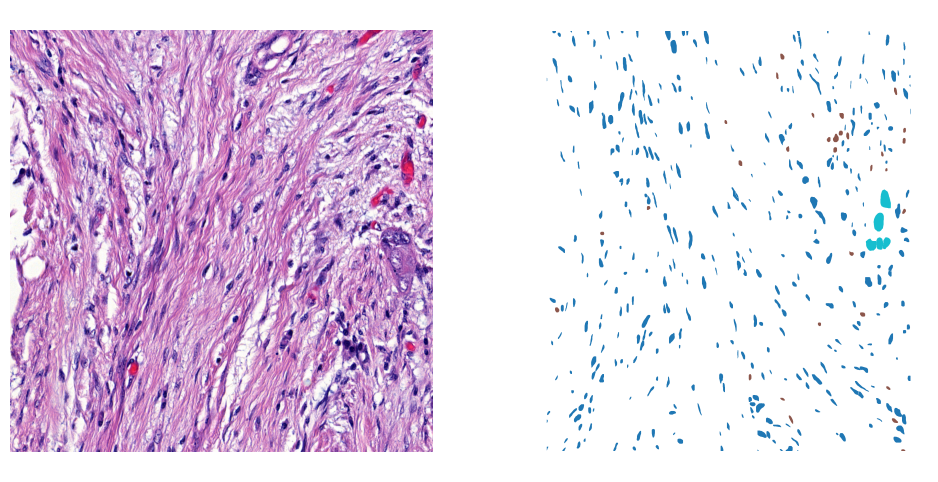

In [1]:
import matplotlib.pyplot as plt
from histolytics.data import hgsc_stroma_he, hgsc_stroma_nuclei

# Example data
nuc = hgsc_stroma_nuclei()
he = hgsc_stroma_he()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(he)
ax[0].set_axis_off()
# note that the gdf has origin in bottom left, thus it is flipped
nuc.plot(ax=ax[1], figsize=(10, 10), column="class_name")
ax[1].set_axis_off()

### Collagen Features

The collagen features are computed from the histology image using the `fiber_feats` function. The corresponding nuclei mask can be used to mask out the nuclear objects which typically improves collagen fiber extraction. The collagen features include metrics such as tortuosity, average turning angle, major and minor axis lengths, and angles, as well as fiber length. These features describe the size, orientation, and level of 'squiggliness' of collagen fibers in the tissue.

NOTE: that parts of the `fiber_feats` function can be gpu accelerated and also parallelized using the `device` and `num_processes` argument to speed up the computations. The gpu acceleration is used when segmenting the collagen fibers and the parallelization is used when computing the features. You can also use the `normalize` argument to quantile normalize the features which is typically a good idea to smooth out the extremes. The `rm_fg` and `rm_bg` arguments can be used to remove foreground (dark stain) and background pixels (light stain) from the feature computation. These arguments can help improve the quality of the collagen fiber segmentation.

,class_name,geometry,tortuosity,average_turning_angle,major_axis_len,minor_axis_len,major_axis_angle,minor_axis_angle,length
0,collagen,"LINESTRING (29.06525 26.95506, 29.03764 26.844...",0.387836,0.306846,0.481968,0.203545,0.385391,0.614914,0.411828
1,collagen,"MULTILINESTRING ((69.19964 89.83999, 69.01369 ...",0.667482,0.612469,0.951406,0.907396,0.688264,0.312042,0.956143
2,collagen,"MULTILINESTRING ((51.54728 1.36606, 51.67797 1...",0.682916,0.563570,0.590770,0.698044,0.978606,0.021546,0.643949


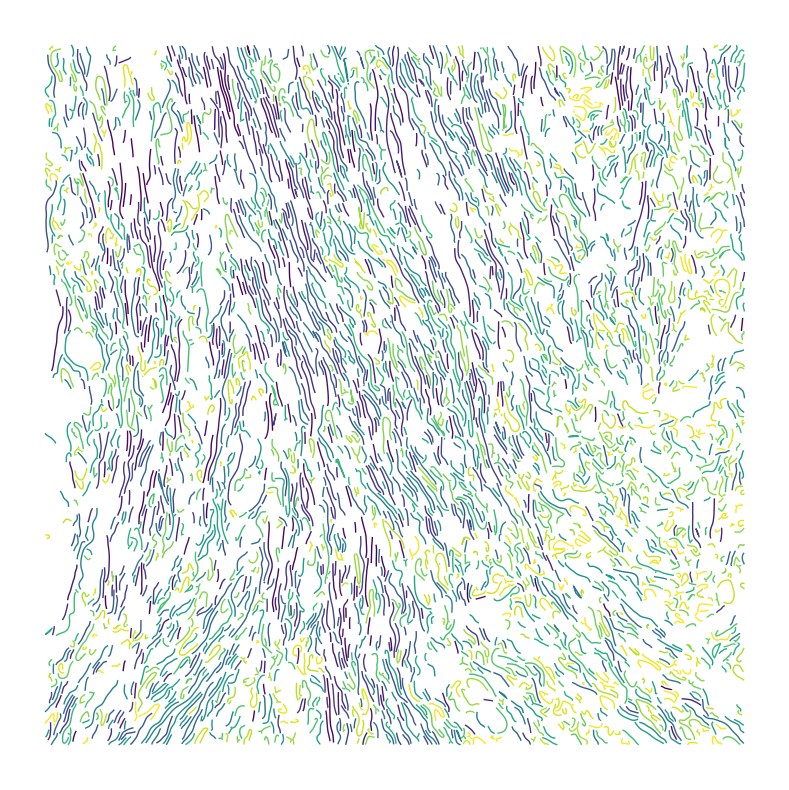

In [2]:
from histolytics.stroma_feats.collagen import fiber_feats
from histolytics.utils.raster import gdf2inst

# convert the nuclei gdf into raster mask for nuclei masking
inst_mask = gdf2inst(nuc, width=he.shape[1], height=he.shape[0])

metrics = [
    "tortuosity",
    "average_turning_angle",
    "major_axis_len",
    "minor_axis_len",
    "major_axis_angle",
    "minor_axis_angle",
    "length",
]

feats = fiber_feats(
    he,
    metrics=metrics,
    label=inst_mask,
    device="cuda",
    num_processes=4,
    normalize=True,
    rm_bg=True,
    rm_fg=False,
    return_edges=True,
)

ax = feats.plot(figsize=(10, 10), aspect=1, column="tortuosity", lw=1)
ax.set_axis_off()
feats.head(3)

#### Collagen Orientation Disorder

As a quick example, we show how to compute the level of collagen orientation disorder. A metric that has been shown to be prognostic in various studies. This will utilize the `local_diversity`-function that was showcased in the [Neighborhood Features](https://hautaniemilab.github.io/histolytics/user_guide/spatial/nhoods) tutorial. First, a graph is fitted to the collagen fiber geometries based on a distance band to define local collagen neighborhoods. Then we compute the Shannon entropy of the major axis angles for every collagen neighborhood. The result is the collagen orientation disorder score for every collagen fiber.

,class_name,geometry,tortuosity,average_turning_angle,major_axis_len,minor_axis_len,major_axis_angle,minor_axis_angle,length,uid,major_axis_angle_shannon_index
uid,,,,,,,,,,,
0,collagen,"LINESTRING (29.06525 26.95506, 29.03764 26.844...",0.387836,0.306846,0.481968,0.203545,0.385391,0.614914,0.411828,0,0.189945
1,collagen,"MULTILINESTRING ((69.19964 89.83999, 69.01369 ...",0.667482,0.612469,0.951406,0.907396,0.688264,0.312042,0.956143,1,0.130960
2,collagen,"MULTILINESTRING ((51.54728 1.36606, 51.67797 1...",0.682916,0.563570,0.590770,0.698044,0.978606,0.021546,0.643949,2,0.134780


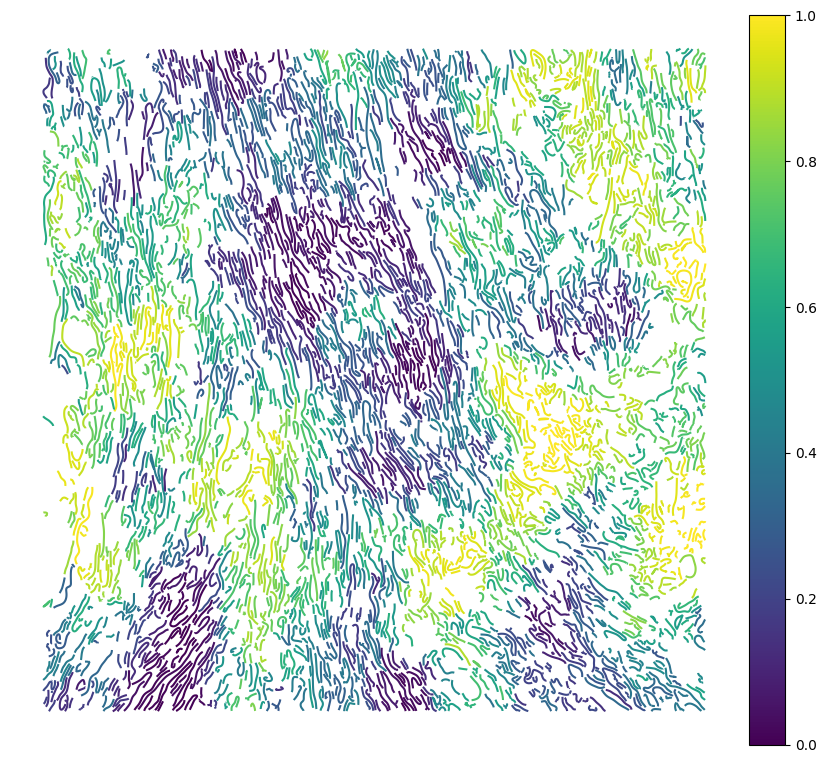

In [3]:
from histolytics.spatial_graph.graph import fit_graph
from histolytics.spatial_agg.local_diversity import local_diversity
from mpl_toolkits.axes_grid1 import make_axes_locatable


# fit a graph to the geometries based on distance band
# and compute the shannon entropy of the major axis angles
wc, wc_gdf = fit_graph(feats, "distband", threshold=100, id_col="uid")
feats = local_diversity(
    feats,
    wc,
    val_cols=["major_axis_angle"],
    metrics=["shannon_index"],
    scheme="percentiles",  # bin the values into percentiles
    k=5,
    normalize=True,  # quantile normalize to smooth the extremes
)

# plot the collagen disorder
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

feats.plot(
    ax=ax, cax=cax, column="major_axis_angle_shannon_index", cmap="viridis", legend=True
)
ax.set_axis_off()

feats.head(3)

### Hematoxylin and Eosin (H&E) Intensity Features

Next, we'll compute intensity based features of the stroma using the `stromal_intensity_feats` function. This function computes the image intensity features of the H&E stain components within the stromal ECM. Before the features are extracted from the input H&E image, a HED decomposition is run on the image to separate the stain components and the intensity features are computed separately for the eosin and hematoxylin components. Similarly to the [nuclear intensity features](https://hautaniemilab.github.io/histolytics/user_guide/spatial/nuclear_features/#intensity-features), the metrics that can be computed from the intensity values are: "min", "max", "mean", "median", "std", "quantiles", "meanmediandiff", "mad", "iqr", "skewness", "kurtosis", "histenergy". Moreover, the `stromal_intensity_feats` function calculates the estimated area of the hematoxylin and eosin stains. These features work are able to capture differences of the H&E stains in the stroma , especially when applied at the WSI-level (See [workflow](https://hautaniemilab.github.io/histolytics/user_guide/spatial/clustering_desmoplasia)).

Note that the `stromal_intensity_feats` function returns a pd.Series containing the computed intensity features. I.e. one feature value per image is returned. Previously, we had computed features per segmented objects and not at patch-level.

Note also that the function can be GPU-accelerated if needed. For example, the HED-decomposition can benefit from GPU acceleration significantly.

In [4]:
from histolytics.stroma_feats.intensity import stromal_intensity_feats

metrics = [
    "max",
    "min",
    "mean",
    "median",
    "std",
    "quantiles",
    "meanmediandiff",
    "mad",
    "iqr",
    "skewness",
    "kurtosis",
    "histenergy",
    "histentropy",
]

intensity_feats = stromal_intensity_feats(
    he,
    label=inst_mask,  # nuclei labels can be used for masking them out
    metrics=metrics,
    device="cpu",
)

intensity_feats

hematoxylin_area        5.455880e+05
hematoxylin_R_max       9.067904e-01
hematoxylin_R_min       7.134423e-08
hematoxylin_R_mean      7.750884e-01
hematoxylin_R_median    8.070443e-01
                            ...     
eosin_B_iqr             4.969945e-03
eosin_B_skewness        7.534861e-03
eosin_B_kurtosis        1.605189e-02
eosin_B_histenergy     -1.495228e+01
eosin_B_histentropy     3.424770e+02
Length: 80, dtype: float32